In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

import torch

from pipeline.interface import get_model

[2023-12-06 21:29:30,780] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
def construct_input_prompt(user_prompt):
    SYSTEM_MESSAGE = "The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.\n"
    IMAGE_TOKEN = "Human: <image>\n" #<image> denotes an image placehold.
    USER_PROMPT = f"Human: {user_prompt}\n"

    return SYSTEM_MESSAGE + IMAGE_TOKEN + USER_PROMPT + "AI: "

In [3]:
# Load trained model
ckpt_path = "checkpoints/13B-C-Abs-M256/last"
model, tokenizer, processor = get_model(ckpt_path, use_bf16=True)
model.cuda()
print("Model initialization is done.")

Loading checkpoint shards: 100%|██████████| 3/3 [00:28<00:00,  9.54s/it]


Model initialization is done.


In [4]:
prompts = [construct_input_prompt("Explain why this meme is funny.")]
image_list = ["./examples/monday.jpg"]

In [5]:
images = [Image.open(_) for _ in image_list]
inputs = processor(text=prompts, images=images)
inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
inputs = {k: v.to(model.device) for k, v in inputs.items()}

In [6]:
# generate kwargs (the same in transformers) can be passed in the do_generate()
generate_kwargs = {
    'do_sample': True,
    'top_k': 5,
    'max_length': 512
}

In [7]:
with torch.no_grad():
    res = model.generate(**inputs, **generate_kwargs)
sentence = tokenizer.batch_decode(res, skip_special_tokens=True)

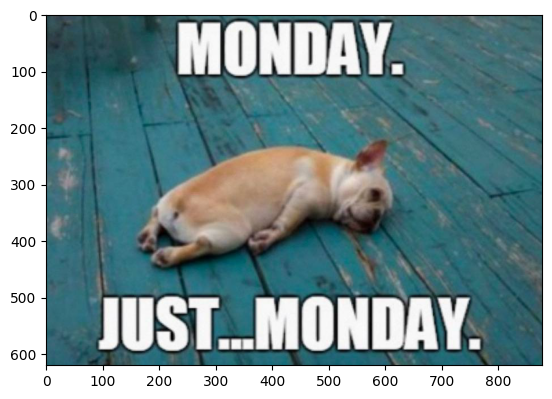

generated: This meme is funny because it uses an adorable French Bulldog puppy lying on a hardwood floor, combined with a humorous and relatable caption. The caption says "Monday. Just…Monday," which implies that even the cute puppy has to endure the challenges of the start of the workweek like everyone else. The meme taps into the shared experience of having a less-than-exciting day and adds a lighthearted, fun twist. The contrast between the innocent puppy and the caption makes it amusing and appealing to a wide audience.


In [8]:
# Show the inference result.
plt.imshow(images[0])
plt.show()
print(f"generated: {sentence[0]}")